# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [0]:
import os
#### Add your code here ####
os.chdir('/content/drive/My Drive/data files/')

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)

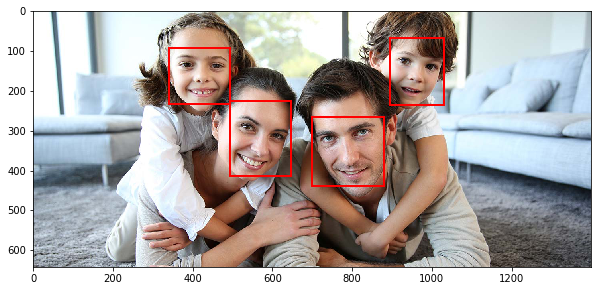

In [0]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))

ax.imshow(data[13][0])
for lbl in data[13][1]:
    rect = patches.Rectangle((lbl['points'][0]['x']*lbl['imageWidth'], lbl['points'][0]['y']*lbl['imageHeight']), lbl['points'][1]['x']*lbl['imageWidth'] - lbl['points'][0]['x']*lbl['imageWidth'], lbl['points'][1]['y']*lbl['imageHeight']- lbl['points'][0]['y']*lbl['imageHeight'], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224#### Add your code here ####
IMAGE_HEIGHT = 224#### Add your code here ####

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [0]:
#### Add your code here ####
X_train.shape

(409, 224, 224, 3)

In [0]:
#### Add your code here ####
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

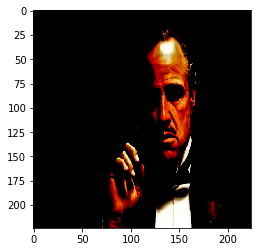

In [0]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

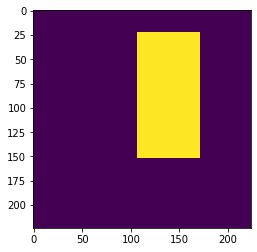

In [0]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28, 28))(x)

    return Model(inputs=model.input, outputs=x)
    

### Call the create_model function

In [0]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
ALPHA=1

model = create_model()

# Print summary
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])


### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [0]:
masks_resize= np.zeros((int(data.shape[0]), 28,28))
for index in range(data.shape[0]):
  masks_resize[index]= cv2.resize(masks[index], dsize=(28,28), interpolation=cv2.INTER_CUBIC)

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [0]:
#### Add your code here ####
model.fit(X_train,masks_resize,batch_size=1, callbacks=[checkpoint, reduce_lr, stop],verbose=1,epochs=40
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 409 samples
Epoch 1/40
406/409 [============================>.] - ETA: 0s - loss: 1.4085 - dice_coefficient: 0.4343
Epoch 00001: loss improved from inf to 1.40411, saving model to model-1.40.h5
409/409 [==============================] - 16s 39ms/sample - loss: 1.4041 - dice_coefficient: 0.4351
Epoch 2/40
406/409 [============================>.] - ETA: 0s - loss: 0.7862 - dice_coefficient: 0.6158
Epoch 00002: loss improved from 1.40411 to 0.78585, saving model to model-0.79.h5
409/409 [==============================] - 9s 21ms/sample - loss: 0.7859 - dice_coefficient: 0.6156
Epoch 3/40
406/409 [============================>.] - ETA: 0s - loss: 0.6252 - dice_coefficient: 0.6753
Epoch 00003: loss improved from 0.78585 to 0.62366, saving model to model-0.62.h5
409/409 [==============================] - 9s 21ms/sample - loss: 0.6237 - dice_coefficient: 0.6763
Epoch 4/40
407/409 [==========

### Get the predicted mask for a sample image   (3 marks)

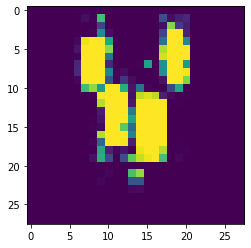

In [0]:
n = 13
sample_image = X_train[13]

#### Add your code here ####

img_pred =model.predict(np.expand_dims(sample_image,axis=0))

pyplot.imshow(img_pred.reshape(28,28))



In [0]:
img_pred =img_pred.reshape(28,28)

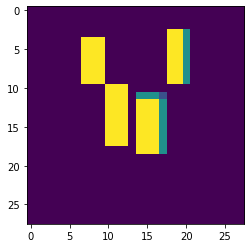

In [0]:
pyplot.imshow(masks_resize[n])

### Impose the mask on the image (3 marks)

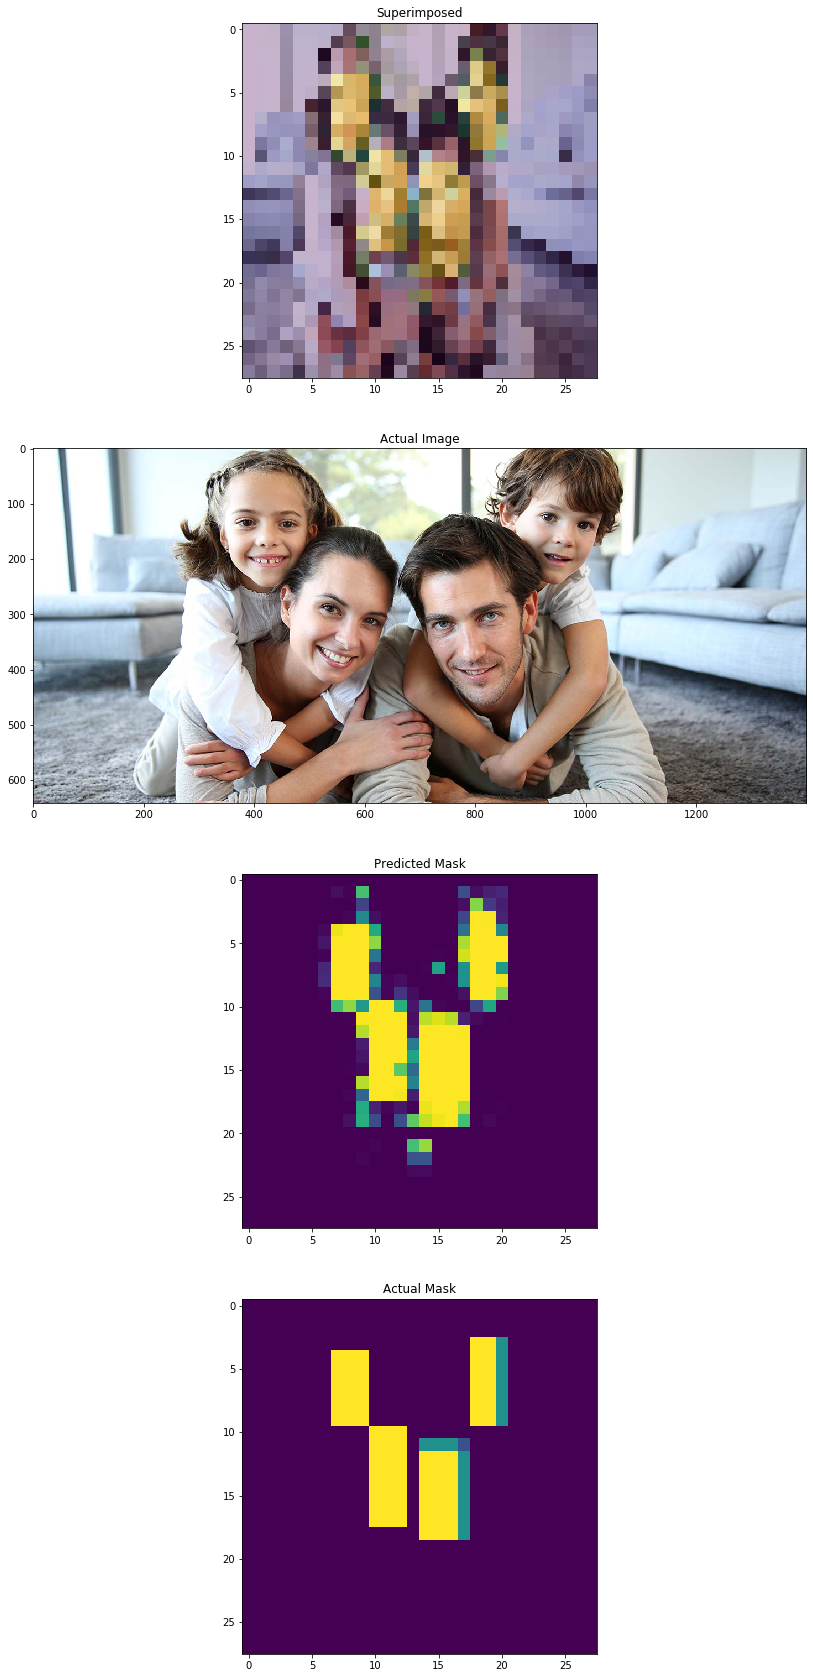

In [0]:

data = np.load('images.npy',allow_pickle=True)

pyplot.figure(figsize=(20,30))
pyplot.subplot(4,1,1)
pyplot.gca().set_title('Superimposed')
pyplot.imshow(cv2.resize(data[n][0],(28,28)))
pyplot.imshow(img_pred.reshape(28,28), alpha=0.3)

pyplot.subplot(4,1,2)
pyplot.gca().set_title('Actual Image')
pyplot.imshow(data[n][0])
pyplot.subplot(4,1,3)
pyplot.gca().set_title('Predicted Mask')
pyplot.imshow(img_pred.reshape(28,28))
pyplot.subplot(4,1,4)
pyplot.gca().set_title('Actual Mask')
pyplot.imshow(masks_resize[n])
